# Portfolio Part 4 - Analysis of Stellar Class Data

In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.

The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

*fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [15 October 2024] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.*

## Question
Using the stellar object dataset, can we evaluate the performance of multiple AI models (such as Neural Networks, Logisitic Regression, K Neighbours Classification, Gaussian NB, Decision Tree and Random Forest) in predicting the class of stellar objects (Galaxies, Quasars, Stars)? How do these models compare in terms of accuracy? Additionally, can we identify which features (e.g., redshift, alpha, delta, z) are most influential in determining the class of stellar objects?

|Column|Meaning|
|:-----|:-----|
|obj_ID| Object Identifier, the unique value that identifies the object in the image catalog used by the CAS|
|alpha| Right Ascension angle (at J2000 epoch)|
|delta| Declination angle (at J2000 epoch)|
|u| Ultraviolet filter in the photometric system|
|g| Green filter in the photometric system|
|r| Red filter in the photometric system|
|i| Near Infrared filter in the photometric system|
|z| Infrared filter in the photometric system|
|run_ID| Run Number used to identify specific scan|
|rerun_ID| Rerun Number to specify how the image was processed|
|cam_col| Camera column to identify the scanline within the run|
|field_ID| Field number to identify each field|
|spec_obj_ID| Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)|
|class| object class (galaxy, star or quasar object)|
|redshift| redshift value based on the increase in wavelength|
|plate| plate ID, identifies each plate in SDSS|
|MJD| Modified Julian Date, used to indicate when a given piece of SDSS data was taken|
|fiber_ID| fiber ID that identifies the fiber that pointed the light at the focal plane in each observation|

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

In [7]:
df_stars_raw = pd.read_csv('star_classification.csv')

In [71]:
# Disable warnings
warnings.filterwarnings("ignore")

# Exploring The Data

In [9]:
print(df_stars_raw.shape)
df_stars_raw.head(10)

(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [13]:
df_stars_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [248]:
# Fixed corrupted values in the dataset
df_stars_raw.replace(-9999, np.nan, inplace=True)
# Count nulls
nullCounter = df_stars_raw.isnull().sum()
print('Nulls found in each column')
print(nullCounter)
print('======================================')

# Row count before cleaning
print('Raw row count:', len(df_stars_raw))
print('======================================')

# Drop rows with missing values
df_stars = df_stars_raw.dropna()

# Row recount after cleaning
print('New row count:', len(df_stars))
print('======================================')

Nulls found in each column
obj_ID         0
alpha          0
delta          0
u              1
g              1
r              0
i              0
z              1
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
Raw row count: 100000
New row count: 99999


#### Analysis
The majority of rows have remained however one row needed to be dropped due to a error in the dataset

In [88]:
# Checking how many classes we have from the "class" column
print("types of classes:", df_stars['class'].nunique())

types of classes: 3


In [90]:
# Check number of samples for each class
print(df_stars['class'].value_counts())
print("======================================")
print("Class dataset make up percentage")
print(df_stars['class'].value_counts()/len(df_stars)*100)

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64
Class dataset make up percentage
class
GALAXY    59.445
STAR      21.594
QSO       18.961
Name: count, dtype: float64


# Graphing The Data

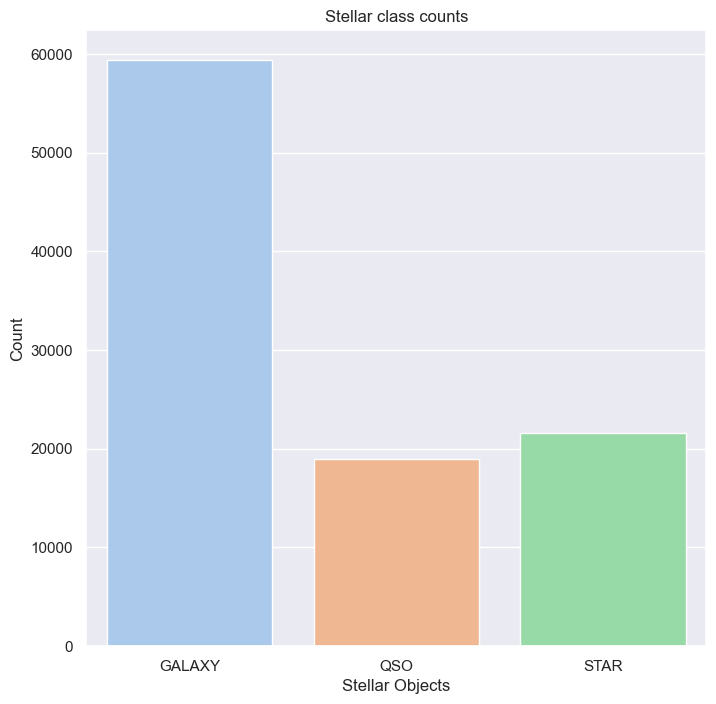

In [254]:
# Graphing the split of classes within the data
plt.figure(figsize=(8,8))
sns.set(style='darkgrid')
sns.countplot(data=df_stars, x="class", hue="class", palette="pastel")
plt.title('Stellar class counts')
plt.xlabel('Stellar Objects')
plt.ylabel('Count')
plt.show()

#### Analysis
The dataset has an extremely disproportionate split of stellar objects with Galaxies making up 59% of the data, this may lead to classification difficulties for the ai models as they may struggle with identifing the other less frequent stellar objects such as stars and quasars. This disproportion in the data collection may be due to the fact that galaxies are extremely abundant within the observable universe, and can be observed from fairly large distances, they are additionally easy to catalogue due to emitting strong signals in multiple wavelengths. Stars are more limited in this aspect, as  they are relatively faint and only detectable in our own galaxy and neighbouting galaxies, therefore are harder to observe. Quasars are even more limited in the data colleection, as although they are extremely luminous objects and easy to observe, they are significantly more rare than galaxies and stars, therefore contributing to theur lower number of datapoints. 

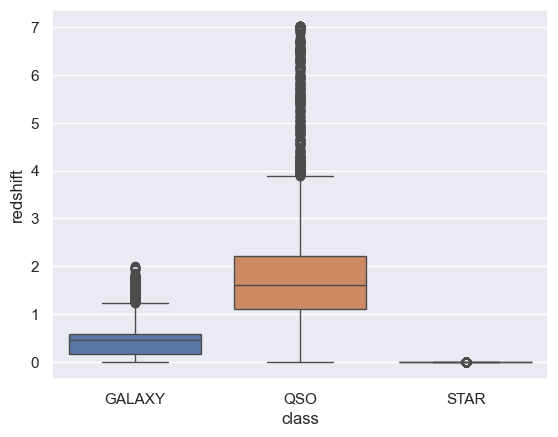

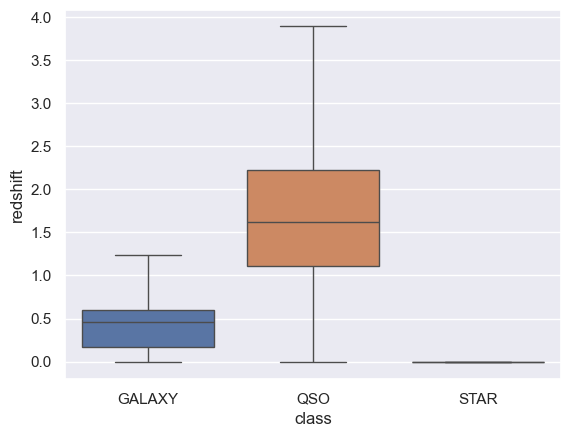

In [23]:
# Graph with outliers
sns.boxplot(df_stars, x='class', y='redshift', hue='class')
plt.show()
# Graph without outliers
sns.boxplot(df_stars, x='class', y='redshift', showfliers=False, hue='class')
plt.show()

#### Analysis 
Quasars Have a significantly larger range as well as a higher peak of redshift, alongside this there are a substaintial amount of outliers in the higher end of the quasar class. This indicates that the recoreded quasars are spread over a larger distance, and when including the outliers it is shown the quasars have been recorded from much deeper in space than other stellar objects such as galaxies and stars, indicating they are moving away from earth at a rapid pace. In contrast, the star objects observed have an extremely small distrubution, even when outliers are considered, which indicates that the dataset is only observing stars within out own galaxy or neighbouring galaxies, and severly limits the distance to which stars can be observed and recorded. The same applied to galaxies, though to a lesser extent as the disribution is slightly larger and higher, it is no where comparable to the high redshift and distrubution of quasars. This difference can be attributed to the fact that quasars are extremely bright and luiminous celestial bodies, and are easy to observe even from billions of light years away, the same can not be said for stars and galaxies, which are significantly less bright and therefore harder to observe at further distances. 

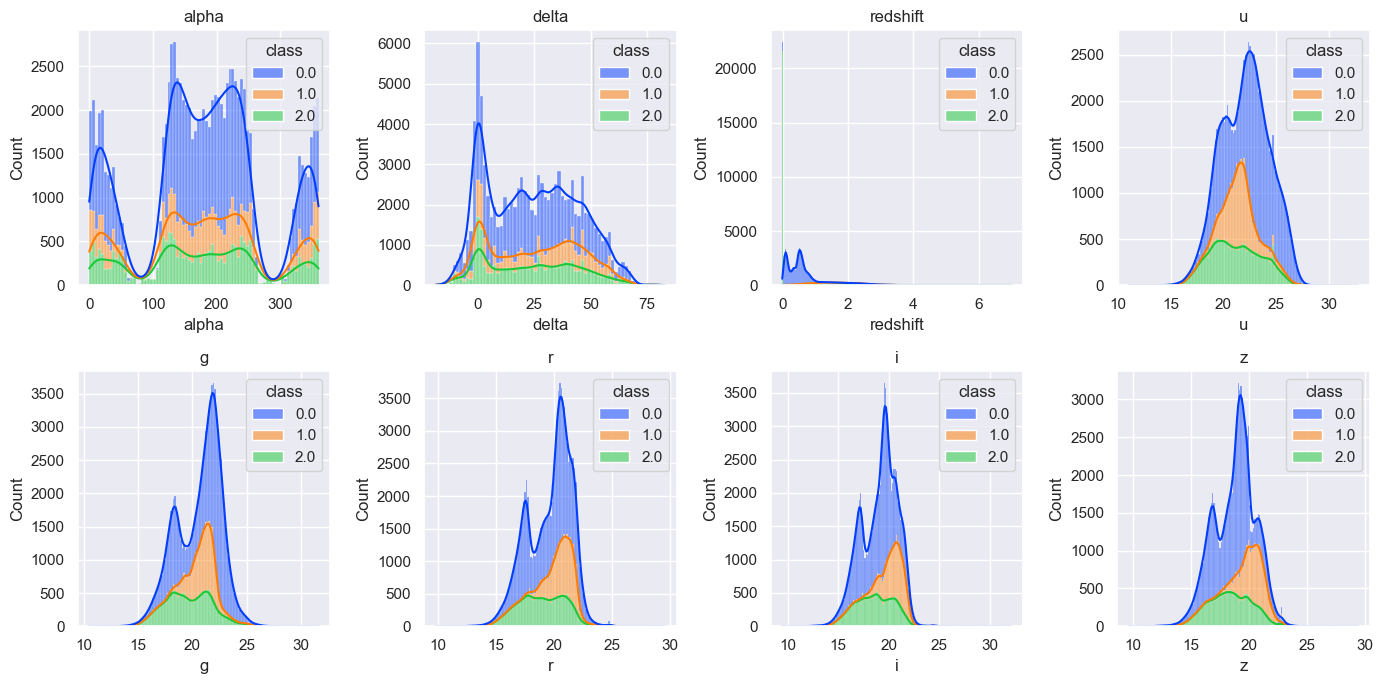

In [208]:
# Set up the grid for subplots
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
sns.set(style='darkgrid')

# Flatten the axes array for indexing
axes = axes.flatten()

# Loop through features to create histograms
for idx, i in enumerate(['alpha', 'delta','redshift','u','g','r','i','z']):
    sns.histplot(data=df_stars, x=i, kde=True, hue="class", palette="bright", multiple="stack", ax=axes[idx])
    axes[idx].set_title(i)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Analysis

X = Variable <br>
Y = Frequency<br>
Hue = Stellar Object Class <br>
| 0.0 = Galaxy | 1.0 = Quasar | 2.0 = Star |

##### Right Ascension (Alpha)

This graph depicts the right ascension angle of the recorded stellar objects this correlates to their position in the sky. The graph shows that for galaxies (0.0) they are distributed broadly across the entire right ascension range (0–360 degrees), with three significant peaks around 50, 200 and 340 degrees. quasars (1.0) and stars (2.0) have much smaller frequencies, but they follow similar general patterns of distribution.

##### Declination (Delta)

The Delta graph represents the declination angle of the recorded stellar objects again correlating to their position in the sky. For galaxies (0.0), the declination values are most common around 10–30 degrees, with some spikes indicating areas of higher object density. The other classes have a lower frequency but still follow a similar distribution, with peaks in similar regions. 

##### Redshift

The graph depicting redshift demonstrates that stars and a number of galaxies have a very low redshift, whereas galaxies and quasars have a much larger redshift. As redshift is a measure of the stretch of the lights wavelength, this demonstrates that the majority of stars observed are very close to the Earth, and are likely within the Milky Way or a neighbouring galaxy, whereas galaxies are measured across a greater range of distances and quasars are typically found much farther away.

##### Ultraviolet filter (u)

The u graph measures the magnitude of light in the ultraviolet spectrum against the frequency of stellar objects with different magnitudes in the u filter. For galaxies (0.0), there is a strong peak around a U magnitude of 22, meaning a large number of objects emit UV light at this magnitude. Quasars (1.0) and stars (2.0) have similar, though smaller peaks, suggesting these objects emit UV light at slightly different frequencies but still in the same range.

##### Green filter (g)

The g graph measures the magnitude of light in the green spectrum against their frequency. There’s a noticeable peak in the frequency of stellar objects with g magnitudes around 23, especially for galaxies (0.0). Quasars (1.0) follows a similar trend but with a lower count, and stars (2.0) contributes only a small number of objects at this magnitude.

##### Red filter (r)

the r graph measures the magnitude of light in the red spectrum against their frequency. The red filter shows similar trends as the green filter, with a dominant peak around magnitude 20 for galaxies (0.0), and smaller but similar peaks for quasars (1.0) and stars (2.0).

##### Near-Infrared filter (i)

the i graph measures the magnitude of light in the near-infrared spectrum against their frequency. Again, there’s a peak near magnitude 20 for galaxies (0.0), suggesting that most objects in this class emit a significant amount of near-infrared light. The distribution for quasars (1.0) and stars (2.0) follows a similar trend with lower frequencies.

##### Infrared filter (z)

graph z measures the magnitude of light in the infrared spectrum against their frequency. This filter also has a peak near magnitude 20 for galaxies (0.0), and smaller but noticeable peaks for quasars (1.0) and stars (2.0), indicating that infrared emissions follow a similar pattern to other wavelengths.


In [73]:
# Initialize encoder
enc = OrdinalEncoder()

# Changing data type from 'object' to 'float' to use the correlation function
df_stars['class'] = enc.fit_transform(df_stars[['class']])

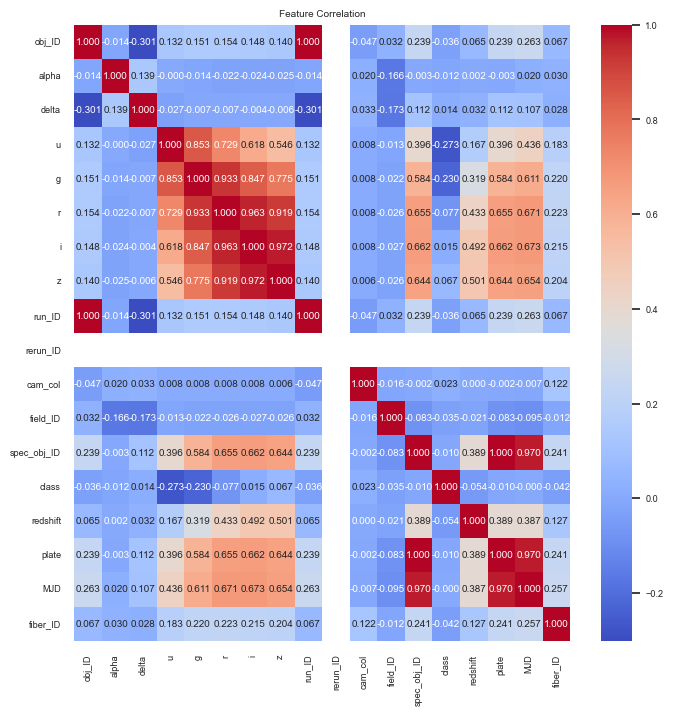

In [141]:
# Correlation heatmap
plt.figure(figsize=(8,8))
sns.set(style="white", font_scale=0.6)
sns.heatmap(df_stars.corr(), cmap="coolwarm", annot=True, fmt="0.3f")
plt.title('Feature Correlation')
plt.show()

#### Analysis
Overall the majority of features have quite weak correlation with the stellar object class the strongest being u (ultraviolet filter in the photometric system) and the weakest being MJD (Modified Julian Date).

# Building AI-Models

## Train / Test Split

In [51]:
# Split the data into 80% training 20% testing
train_stars, test_stars = train_test_split(df_stars, test_size=0.2, random_state=47619139)

In [53]:
# Checking dataset sizes after split
print(train_stars.shape)
print(test_stars.shape)

(79999, 18)
(20000, 18)


In [55]:
# Setting the target and feature variables
# Training Data
X_train_stars = train_stars.drop("class", axis=1)
y_train_stars = train_stars["class"]

# Testing Data
X_test_stars = test_stars.drop("class", axis=1)
y_test_stars = test_stars["class"]

In [57]:
# Initialize Standard Scaler for feature scaling
scaler = StandardScaler()

# Fit scaler on training data and transform it
X_train_stars_scaled = scaler.fit_transform(X_train_stars)

# Transform the testing data using the fitted scaler
X_test_stars_scaled = scaler.transform(X_test_stars)

## Neural Network

In [59]:
# Initialize MLP Classifier with specified architecture and parameters
clf_NN1 = MLPClassifier(hidden_layer_sizes=(200,100,50,25),
                    activation='relu',
                    solver="sgd",
                    alpha=0.00001,
                    batch_size='auto',
                    learning_rate='adaptive',
                    learning_rate_init=0.0001,
                    max_iter=10000,
                    shuffle=True,
                    random_state=47619139,
                    early_stopping=True)

# Train the classifier on the scaled training data
clf_NN1.fit(X_train_stars_scaled, y_train_stars)

MLPClassifier(alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0.0001, max_iter=10000, random_state=47619139,
              solver='sgd')

In [60]:
# Predict testing data
y_pred_NN1 = clf_NN1.predict(X_test_stars_scaled)

In [61]:
# Show the testing performance
scoreNN1 = metrics.accuracy_score(y_test_stars, y_pred_NN1)
f1NN1 = metrics.f1_score(y_test_stars, y_pred_NN1, average='weighted')
print("The accuracy is: ", scoreNN1)
print("The F1 Score is:", f1NN1)

The accuracy is:  0.96425
The F1 Score is: 0.9639981678437002


Confusion Matrix for Test Set:


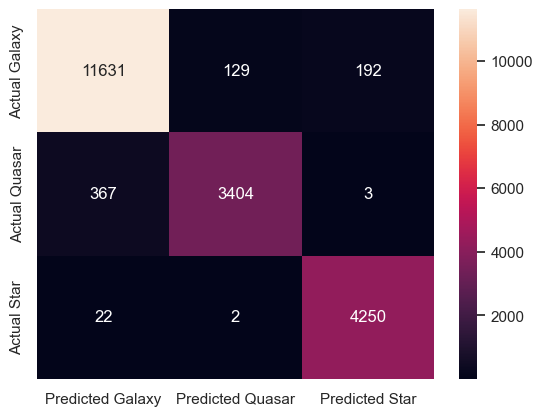

In [211]:
# Compute confusion matrix for test set
test_conf_matrix_NN1 = metrics.confusion_matrix(y_test_stars, y_pred_NN1)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_NN1, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
The confusion matrix for the Neural Network highlights the areas it excels in such as its accuracy at correctly classifying stars, while also giving me insight into which of the stellar objects the model is struggling to classify such as its ability to differentiate between quasars and galaxies. This may be due to quasars and galaxies having many overlapping features, such as refshift, as these differences are more subtle, the neural network may have trouble classifying these correctly. There are also fewer quasars within the dataset, and an abundance of galaxies,  this imbalance may further contribute to the models issues in differentiating the two, as it lacks the ability to learn about the unique features that differenciate quasars from galaxies. Therefore while it may easily identify the stars, it has more trouble identifying galaxies and quasars. 

## Logistic Regression

In [75]:
# Initialize Logistic Regression with a maximum of 10,000 iterations
clf_LR = linear_model.LogisticRegression(max_iter = 10000)

# Train the classifier on the scaled training data
clf_LR.fit(X_train_stars_scaled, y_train_stars)

LogisticRegression(max_iter=10000)

In [76]:
# Predict testing data
y_pred_LR = clf_LR.predict(X_test_stars_scaled)

In [77]:
# Show the testing performance
scoreLR = metrics.accuracy_score(y_test_stars, y_pred_LR)
f1LR = metrics.f1_score(y_test_stars, y_pred_LR, average='weighted')
print("The accuracy is: ", scoreLR)
print("The F1 Score is:", f1LR)

The accuracy is:  0.95785
The F1 Score is: 0.95744405033373


Confusion Matrix for Test Set:


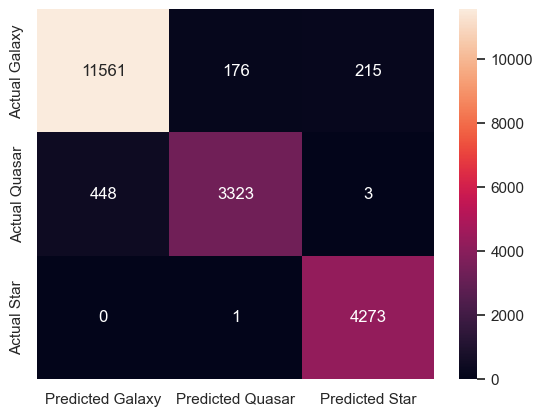

In [213]:
# Compute confusion matrix for test set
test_conf_matrix_LR = metrics.confusion_matrix(y_test_stars, y_pred_LR)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_LR, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
Once again the model is very accurately classifying the stars but struggling to differentiate between quasars and galaxies, this is likely due to the imbalance of the dataset having the least amount of training on quasar data, and stars having the most distinct features of the classes, while quasars and galaxies share many overlapping values and features.

## KNeighborsClassifier

In [84]:
# Initialize K-Nearest Neighbors Classifier with 1 neighbor
knn = KNeighborsClassifier(n_neighbors = 1)

# Train the classifier on the scaled training data
knn.fit(X_train_stars_scaled, y_train_stars)

KNeighborsClassifier(n_neighbors=1)

In [86]:
# Predict testing data
y_pred_KNN = knn.predict(X_test_stars_scaled)

In [87]:
# Show the testing performance
scoreKNN = metrics.accuracy_score(y_test_stars, y_pred_KNN)
f1KNN = metrics.f1_score(y_test_stars, y_pred_KNN, average='weighted')
print("The accuracy is: ", scoreKNN)
print("The F1 Score is:", f1KNN)

The accuracy is:  0.90445
The F1 Score is: 0.9038342433452421


Confusion Matrix for Test Set:


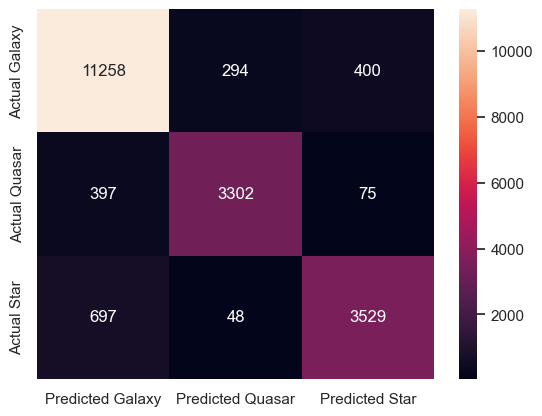

In [215]:
# Compute confusion matrix for test set
test_conf_matrix_KNN = metrics.confusion_matrix(y_test_stars, y_pred_KNN)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_KNN, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
This model is the first that was most successful at correctly classifying quasars however overall it was one of the worse performing models, this potentially could be improved via better data processing as well as adjusting the neighbors value. As KNN works by looking at the nearest k features in the feature space, it was able to identify the clusters that the quasar data formed, as KNN focuses on local similarities such as high redshift values. 

## GaussianNB

In [93]:
# Initialize GaussianNB Classifier
clf_GNB = GaussianNB()

# Train the classifier on the scaled training data
clf_GNB.fit(X_train_stars_scaled, y_train_stars)

GaussianNB()

In [95]:
# Predict testing data
y_pred_GNB = clf_GNB.predict(X_test_stars_scaled)

In [97]:
# Show the testing performance
scoreGNB = metrics.accuracy_score(y_test_stars, y_pred_GNB)
f1GNB = metrics.f1_score(y_test_stars, y_pred_GNB, average='weighted')
print("The accuracy is: ", scoreGNB)
print("The F1 Score is:", f1GNB)

The accuracy is:  0.8833
The F1 Score is: 0.88849475807104


Confusion Matrix for Test Set:


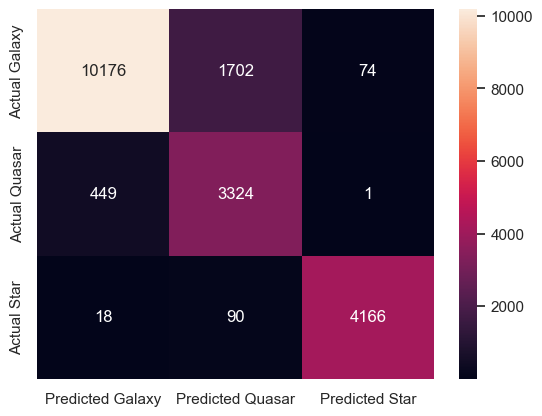

In [217]:
# Compute confusion matrix for test set
test_conf_matrix_GNB = metrics.confusion_matrix(y_test_stars, y_pred_GNB)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_GNB, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
This model was the overall worst performing having significant difficulty when trying to predict stars frequently leaning towards classifying the data as galaxies likely due to the very disproportionate dataset. GaussianNB also assumes that all features are indepenedent, however in this astronomy based dataset, many of the features such as u, g, and r are related, therefore leading to poorer performance. It also has a limited ability to overcome issues with overlapping features, causing the model to be confused.

## Decision Tree Classifier

In [102]:
# Initialize Decision Tree Classifier with entropy criterion, fixed random state, and maximum depth of 9
clf_DTC = DecisionTreeClassifier(criterion='entropy', random_state=2, max_depth=9)

# Train the classifier on the scaled training data
clf_DTC.fit(X_train_stars_scaled, y_train_stars)

DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=2)

In [103]:
# Predict testing data
y_pred_DTC = clf_DTC.predict(X_test_stars_scaled)

In [104]:
# Show the testing performance
scoreDTC = metrics.accuracy_score(y_test_stars, y_pred_DTC)
f1DTC = metrics.f1_score(y_test_stars, y_pred_DTC, average='weighted')
print("The accuracy is: ", scoreDTC)
print("The F1 Score is:", f1DTC)

The accuracy is:  0.97555
The F1 Score is: 0.9753243749398551


Confusion Matrix for Test Set:


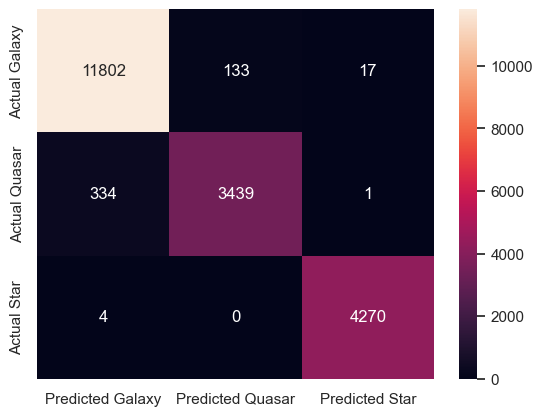

In [219]:
# Compute confusion matrix for test set
test_conf_matrix_DTC = metrics.confusion_matrix(y_test_stars, y_pred_DTC)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_DTC, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
The Decision Tree Classifer was the second most accurate model overall with amazing accuracy at classifying stars correctly, similar to previous models the most challenging class to accurately predict was quasars, likely due to their underrepresentation in the dataset.

## Random Forest Classifier

In [111]:
# Initialize Random Forest Classifier with 17 trees and a fixed random state
clf_RFC = RandomForestClassifier(n_estimators = 17, random_state = 2)

# Train the classifier on the scaled training data
clf_RFC.fit(X_train_stars_scaled, y_train_stars)

RandomForestClassifier(n_estimators=17, random_state=2)

In [112]:
# Predict testing data
y_pred_RFC = clf_RFC.predict(X_test_stars_scaled)

In [113]:
# Show the testing performance
scoreRFC = metrics.accuracy_score(y_test_stars, y_pred_RFC)
f1RFC = metrics.f1_score(y_test_stars, y_pred_RFC, average='weighted')
print("The accuracy is: ", scoreRFC)
print("The F1 Score is:", f1RFC)

The accuracy is:  0.97735
The F1 Score is: 0.9771831870883306


Confusion Matrix for Test Set:


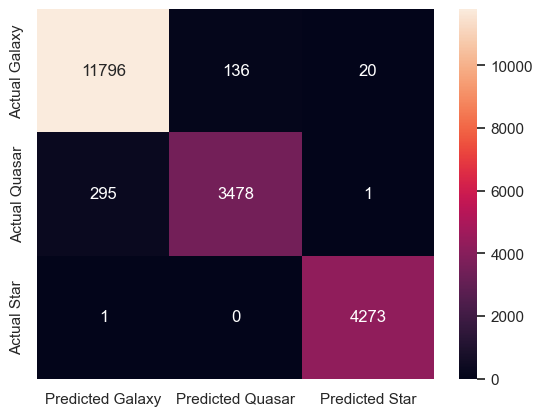

In [221]:
# Compute confusion matrix for test set
test_conf_matrix_RFC = metrics.confusion_matrix(y_test_stars, y_pred_RFC)

# Display confusion matrix as a heatmap
print("Confusion Matrix for Test Set:")
sns.heatmap(test_conf_matrix_RFC, annot=True, fmt='d', cmap='rocket', 
            xticklabels=['Predicted Galaxy', 'Predicted Quasar', 'Predicted Star'], 
            yticklabels=['Actual Galaxy', 'Actual Quasar', 'Actual Star'])
plt.show()

#### Analysis
The Random Forest Classifer was overall the best performing model reaching nearly 98% accuracy, similarly to the other models the most challenging class to correctly predict correctly was quasars however with a more balanced data set would likely have been able to reach even higher in terms of accuracy. Random forest classifiers excel as they have the ability to properly handle correlated features and average predictions across multiple decision trees.

## Feature Elimination

### Recursive Feature Elimination with Cross Validation

In [124]:
# Models
# List of estimators
estimators = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier(criterion='entropy', random_state=2, max_depth=9)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators = 17, random_state = 2))
]

# Get feature names
feature_names = X_train_stars.columns

In [126]:
# Create DataFrame for scaled training data
X_train_stars_scaled_df = pd.DataFrame(X_train_stars_scaled, columns=feature_names)

# Loop over the estimators
for name, estimator in estimators:
    # Set up RFECV for feature selection
    rfecv = RFECV(estimator, step=1, cv=5, scoring='balanced_accuracy')
        
    # Fit RFECV on the training data
    rfecv.fit(X_train_stars_scaled_df, y_train_stars)

    # Transform the training and testing data to keep only selected features
    X_train_stars_scaled_selected = rfecv.transform(X_train_stars_scaled_df)
    X_test_stars_scaled_selected = rfecv.transform(X_test_stars_scaled)

    # Fit the estimator on the selected features
    estimator.fit(X_train_stars_scaled_selected, y_train_stars)

    # Predict on the test set
    y_pred_est = estimator.predict(X_test_stars_scaled_selected)

    # Calculate accuracy
    accuracy_est = metrics.accuracy_score(y_test_stars, y_pred_est)
    
    # Get the selected features using get_support()
    selected_features_mask = rfecv.get_support()
    
    # Get the names of the selected features
    selected_features = X_train_stars_scaled_df.columns[selected_features_mask]

    # Print accuracy and selected features
    print(name, 'Accuracy:', accuracy_est)
    print('Selected Features:', list(selected_features))

Logistic Regression Accuracy: 0.95755
Selected Features: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'redshift', 'plate', 'MJD', 'fiber_ID']
Decision Tree Accuracy: 0.97525
Selected Features: ['u', 'g', 'i', 'z', 'spec_obj_ID', 'redshift']
RandomForestClassifier Accuracy: 0.9788
Selected Features: ['u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']


### SelectKBest

In [132]:
# List of estimators
estimators2 = [
    ('Neural Network', MLPClassifier(hidden_layer_sizes=(200,100,50,25),
                                     activation='relu',
                                     solver="sgd",
                                     alpha=0.00001,
                                     batch_size='auto',
                                     learning_rate='adaptive',
                                     learning_rate_init=0.0001,
                                     max_iter=10000,
                                     shuffle=True,
                                     random_state=47619139,
                                     early_stopping=True)),
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier(n_neighbors=1)),
    ('GaussianNB', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(criterion='entropy', random_state=2, max_depth=9)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators = 17, random_state = 2))
]

In [134]:
# Convert to a pandas DataFrame
X_train_stars_scaled_df = pd.DataFrame(X_train_stars_scaled, columns=feature_names)
X_test_stars_scaled_df = pd.DataFrame(X_test_stars_scaled, columns=feature_names)


for name, estimator in estimators2:
    # Select top 8 features using SelectKBest
    selector = SelectKBest(score_func=f_classif, k=8) 
    selector.fit(X_train_stars_scaled, y_train_stars)
    
    # Get indices of selected features
    selected_indices = selector.get_support(indices=True)
    
    # Map indices to feature names
    selected_features = [feature_names[i] for i in selected_indices] 
    
    # Transform the data using the selected features
    X_train_stars_scaled_selected2 = selector.transform(X_train_stars_scaled)
    X_test_stars_scaled_selected2 = selector.transform(X_test_stars_scaled)
    
    # Train the estimator on the selected features
    estimator.fit(X_train_stars_scaled_selected2, y_train_stars)
    
    # Make predictions
    y_pred_est2 = estimator.predict(X_test_stars_scaled_selected2)
    
    # Calculate accuracy
    accuracy_est = metrics.accuracy_score(y_test_stars, y_pred_est2)
    
    # Print accuracy and selected features
    print(name, 'Accuracy:', accuracy_est, 'Selected Features:', selected_features)

Neural Network Accuracy: 0.9641 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']
Logistic Regression Accuracy: 0.9559 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']
KNN Accuracy: 0.94515 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']
GaussianNB Accuracy: 0.872 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']
Decision Tree Accuracy: 0.973 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']
RandomForestClassifier Accuracy: 0.9765 Selected Features: ['u', 'r', 'i', 'z', 'spec_obj_ID', 'redshift', 'plate', 'MJD']


#### Analysis
##### RFECV 
After performing feature elimination and testing new measured accuracy the models have shown little to no improvement 2/3 even performing worse. Each model selected a different number of features as optimal for producing the most accurate results with features u, g, i, z, spec_obj_ID and redshift being selected 3/3 times. Overall the best performing model was the Random Forest Classifier model with 9 of the 17 features selected achieving an accuracy score of 0.9788.

##### SelectKBest
The 8 features selected by SelectKBest were u, r, i, z, spec_obj_ID, redshift, plate and MJD. However with the limit of only being able to select 8 features the majority of models ended up performing worse with only two models showing improvment (1-KNN). The reason for the underperformance is likely due to each model having their own unique way of handling the data leading to them each performing best at their own specific number of features.

|Model|Before|After (RFECV)|After (SelectKBest)|Features Selected (RFECV)|Features Selected (SelectKBest)|
|:-----|:-----|:-----|:-----|:-----|:-----|
|Neural Network (MLP)|96.43%|----|96.41%|----|8|
|Logistic Regression|95.79%|95.76%|95.59%|15|8|
|KNeighborsClassifier|90.45%|----|94.52%|----|8|
|GaussianNB|88.33%|----|87.20%|----|8|
|Decision Tree Classifier|97.56%|97.53%|97.30%|6|8|
|RandomForestClassifier|97.74%|97.88%|97.65%|9|8|

##### Overall
RFECV managed to identify a minimum number of features required to achieve similar results to having access to all features, whereas SelectKBest while showing a lower performance in many of the models managed to improve the 1-KNN model by a noteable amount. further feature analysis may provide other models to increase in accuracy as well however 5/6 managed to surpass the 90% accuracy threshhold performing excellently. The most noteable and commonly selected features across both feature selection methods were u, i, z, spec_obj_ID and redshift being selected ever time by all models. MJD was a feature selected frequently which was a surprise to me as when looking at the correlation heatmap with class MJD was the lowest correlated feature sitting at 0, however in both tests RFECV and SelectKBest MJD managed to be selected a total of 8/9 times. The top performing model across all categories was the Random Forest Classifer with RFECV features selected achieving 97.88% accuracy making it the most ideal for classifying stellar objects.

### Conclusion

Using the stellar object dataset, I evaluated the performance of Neural Networks, Logisitic Regression, K Neighbours Classification, Gaussian NB, Decision Tree and Random Forest models at predicting the class of stellar objects. The ending results demonstrated that the most ideal model for this task was a Random Forest Classifer with RFECV features selected achieving 97.88% accuracy. Additionally the best features for determining the class of the stellar objects was found to be u, i, z, spec_obj_ID and redshift.